# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set a more attractive Seaborn style/theme
sns.set_theme(style='whitegrid', palette='pastel')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set a more attractive Seaborn style/theme
sns.set_theme(style='whitegrid', palette='pastel')

# Read CSV Data


In [2]:
def read_csv_data(filepath):
    """
    Reads a CSV file containing at least two columns: 'StudentID' and 'Score'.
    Returns a pandas DataFrame or raises an Exception if the file is missing columns.
    """
    try:
        df = pd.read_csv(filepath)
        display(df.head())  # Display the first few rows of the dataframe
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find the file: {filepath}")
    except Exception as e:
        raise Exception(f"An error occurred while reading the CSV: {e}")

    # Basic error handling for missing columns
    required_cols = {'StudentID', 'Score'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"CSV file must contain columns: {required_cols}")

    return df

# Example usage
filepath = "/content/StudentScores.csv"  # Update with your file path
df = read_csv_data(filepath)

,StudentID,Score
0,1,97
1,2,81
2,3,74
3,4,62
4,5,88


# Assign Absolute Grades


In [3]:
def assign_absolute_grade(score, thresholds=None):
    """
    Assigns an absolute letter grade based on fixed numeric thresholds.
    Example thresholds:
    {
        'A': 90,
        'B': 80,
        'C': 70,
        'D': 60
    }
    """
    if thresholds is None:
        thresholds = {'A': 90, 'B': 80, 'C': 70, 'D': 60}

    if score >= thresholds['A']:
        return 'A'
    elif score >= thresholds['B']:
        return 'B'
    elif score >= thresholds['C']:
        return 'C'
    elif score >= thresholds['D']:
        return 'D'
    else:
        return 'F'

# Example usage
df['Grade'] = df['Score'].apply(assign_absolute_grade)
display(df.head())

,StudentID,Score,Grade
0,1,97,A
1,2,81,B
2,3,74,C
3,4,62,D
4,5,88,B


# Transform Scores to Normal Curve


In [4]:
# Transform Scores to Normal Curve

def transform_scores_normal_curve(df):
    """
    Performs z-score scaling (normal-curve approach) on 'Score'.
    1) Compute mean and std of the scores
    2) Convert each score to a z-score
    3) Rescale z-scores to e.g. 0-100 range (optional) or keep them as z-scores
    Returns a DataFrame with a new column 'AdjustedScore' reflecting the transformation.
    """
    df_new = df.copy()
    mu = df['Score'].mean()
    sigma = df['Score'].std()

    if sigma == 0:
        # All scores are identical; no transformation
        df_new['AdjustedScore'] = df['Score']  # or just keep them the same
        return df_new

    # Standard z-score
    z_scores = (df['Score'] - mu) / sigma

    # Optionally, you could map z-scores to some 0-100 scale. For demonstration:
    #   z_min, z_max = z_scores.min(), z_scores.max()
    #   z_range = z_max - z_min
    #   AdjustedScore = (z_scores - z_min) / z_range * 100
    #
    # But often we just keep the z-score as is, or keep the original scores for letter assignment.
    # We'll do a simple approach: keep z-scores in a new column
    df_new['AdjustedScore'] = z_scores
    return df_new

# Example usage
df_transformed = transform_scores_normal_curve(df)
display(df_transformed.head())

,StudentID,Score,Grade,AdjustedScore
0,1,97,A,1.451610
1,2,81,B,0.373014
2,3,74,C,-0.098871
3,4,62,D,-0.907818
4,5,88,B,0.844900


# Assign Letter Grades from Percentiles


In [5]:
# Assign Letter Grades from Percentiles

def assign_letter_grades_from_percentiles(df, grade_col='FinalGrade'):
    """
    Assign letter grades based on the percentile of 'AdjustedScore' in a normal distribution.
    By default:
      - A: top 20% (percentile >= 0.80)
      - B: next 30% (0.50 to 0.80)
      - C: next 30% (0.20 to 0.50)
      - D: next 10% (0.10 to 0.20)
      - F: bottom 10% (0.00 to 0.10)
    Stores the letter grade in df[grade_col].
    """
    df_new = df.copy()
    if 'AdjustedScore' not in df_new.columns:
        df_new['AdjustedScore'] = df_new['Score']

    if df_new['AdjustedScore'].nunique() == 1:
        df_new[grade_col] = 'C'
        return df_new

    z_scores = df_new['AdjustedScore']
    percentiles = norm.cdf(z_scores)

    letter_bins = {'A': 0.80, 'B': 0.50, 'C': 0.20, 'D': 0.10, 'F': 0.00}
    letter_grades = []
    for p in percentiles:
        if p >= letter_bins['A']:
            letter_grades.append('A')
        elif p >= letter_bins['B']:
            letter_grades.append('B')
        elif p >= letter_bins['C']:
            letter_grades.append('C')
        elif p >= letter_bins['D']:
            letter_grades.append('D')
        else:
            letter_grades.append('F')

    df_new[grade_col] = letter_grades
    return df_new

# Example usage
df_final = assign_letter_grades_from_percentiles(df_transformed)
display(df_final.head())

,StudentID,Score,Grade,AdjustedScore,FinalGrade
0,1,97,A,1.451610,A
1,2,81,B,0.373014,B
2,3,74,C,-0.098871,C
3,4,62,D,-0.907818,D
4,5,88,B,0.844900,A


# Assign Relative Grade Distribution


In [6]:
# Assign Relative Grade Distribution

def assign_relative_grade_distribution(df, distribution=None, grade_col='FinalGrade'):
    """
    Forces letter grades by sorting from highest to lowest Score and assigning
    top X% to 'A', next Y% to 'B', etc., based on the given distribution.
    """
    df_new = df.copy()

    if distribution is None:
        distribution = {'A': 0.20, 'B': 0.30, 'C': 0.30, 'D': 0.10, 'F': 0.10}

    # Sort scores descending
    sorted_df = df_new.sort_values(by='Score', ascending=False).reset_index(drop=True)
    n = len(sorted_df)

    # Convert percentages to counts
    grade_counts = {}
    for g, pct in distribution.items():
        grade_counts[g] = int(round(pct * n))

    # Correct rounding errors
    diff = n - sum(grade_counts.values())
    if diff != 0:
        last_grade = list(distribution.keys())[-1]
        grade_counts[last_grade] += diff

    # Assign
    assigned_grades = [''] * n
    start_idx = 0
    for g in distribution.keys():
        count = grade_counts[g]
        end_idx = start_idx + count
        for i in range(start_idx, end_idx):
            assigned_grades[i] = g
        start_idx = end_idx

    sorted_df[grade_col] = assigned_grades

    # Merge back with original order
    df_merged = pd.merge(df_new, sorted_df[['StudentID', grade_col]], on='StudentID', how='left')
    return df_merged

# Example usage
df_relative = assign_relative_grade_distribution(df)
display(df_relative.head())

,StudentID,Score,Grade,FinalGrade
0,1,97,A,A
1,2,81,B,B
2,3,74,C,C
3,4,62,D,C
4,5,88,B,B


,StudentID,Score
0,1,97
1,2,81
2,3,74
3,4,62
4,5,88



=== ORIGINAL SCORES STATISTICS ===
Mean Score         : 75.47
Variance           : 220.05
Standard Deviation : 14.83
Skewness           : -0.17



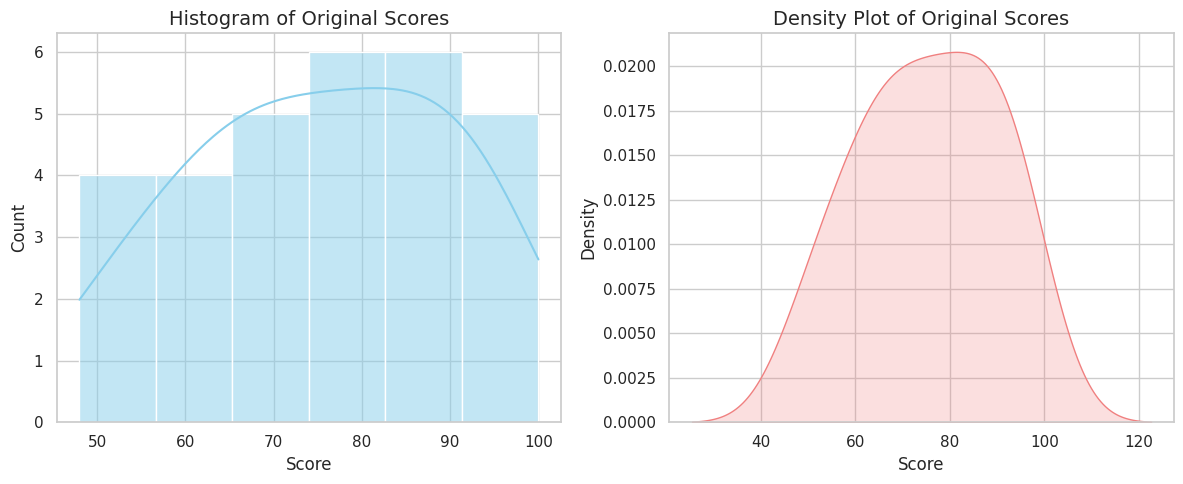

=== FINAL GRADE DISTRIBUTION (RELATIVE) ===
Grade A: 8 students
Grade B: 7 students
Grade C: 8 students
Grade D: 3 students
Grade F: 4 students



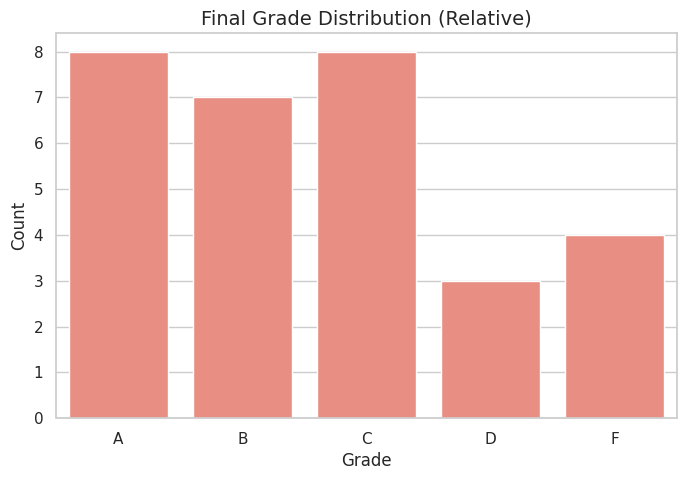

=== Adjusted Scores Analysis (for Relative Grading) ===
Adjusted Mean: -0.00
Adjusted Std : 1.00



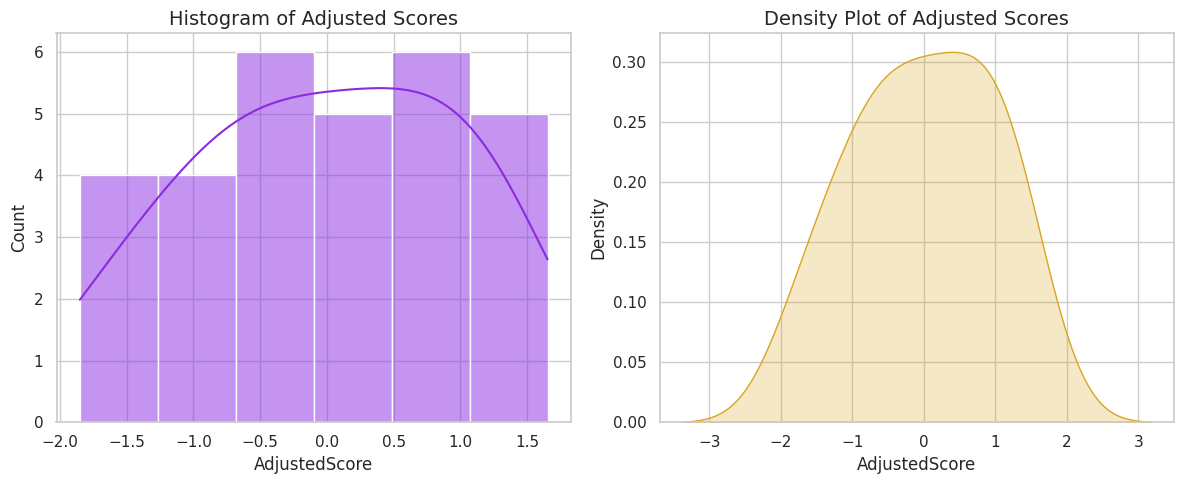

Number of students who changed letter grade compared to absolute grading: 8

Process completed successfully!
Feel free to modify thresholds, distributions, or methods.
 - Switch between 'absolute' and 'relative' in grading_method.
 - For 'relative', choose 'normal_curve' or 'distribution' in relative_approach.



In [7]:
def main():
    filepath = "/content/StudentScores.csv"  # update if needed
    df = read_csv_data(filepath)

    grading_method = 'relative'
    relative_approach = 'normal_curve'
    abs_thresholds = {'A': 90, 'B': 80, 'C': 70, 'D': 60}
    rel_distribution = {'A': 0.20, 'B': 0.30, 'C': 0.30, 'D': 0.10, 'F': 0.10}

    mean_score = df['Score'].mean()
    var_score = df['Score'].var()
    std_score = df['Score'].std()
    skew_score = df['Score'].skew()

    print("\n=== ORIGINAL SCORES STATISTICS ===")
    print(f"Mean Score         : {mean_score:.2f}")
    print(f"Variance           : {var_score:.2f}")
    print(f"Standard Deviation : {std_score:.2f}")
    print(f"Skewness           : {skew_score:.2f}\n")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df['Score'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title("Histogram of Original Scores", fontsize=14)
    axes[0].set_xlabel("Score")
    axes[0].set_ylabel("Count")
    sns.kdeplot(df['Score'], fill=True, ax=axes[1], color='lightcoral')
    axes[1].set_title("Density Plot of Original Scores", fontsize=14)
    axes[1].set_xlabel("Score")
    axes[1].set_ylabel("Density")
    plt.tight_layout()
    plt.show()

    df_grading = df.copy()

    if grading_method.lower() == 'absolute':
        df_grading['Grade'] = df_grading['Score'].apply(assign_absolute_grade, thresholds=abs_thresholds)
        df_grading['AdjustedScore'] = df_grading['Score']
    else:
        if relative_approach == 'normal_curve':
            df_transformed = transform_scores_normal_curve(df_grading)
            df_final = assign_letter_grades_from_percentiles(df_transformed, grade_col='Grade')
            df_grading = df_final.copy()
        else:
            df_final = assign_relative_grade_distribution(df_grading, distribution=rel_distribution, grade_col='Grade')
            df_final['AdjustedScore'] = df_final['Score']
            df_grading = df_final.copy()

    final_counts = df_grading['Grade'].value_counts().sort_index()
    print(f"=== FINAL GRADE DISTRIBUTION ({grading_method.upper()}) ===")
    for g, cnt in final_counts.items():
        print(f"Grade {g}: {cnt} students")
    print()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=final_counts.index, y=final_counts.values, color='salmon')
    plt.title(f"Final Grade Distribution ({grading_method.capitalize()})", fontsize=14)
    plt.xlabel("Grade")
    plt.ylabel("Count")
    plt.show()

    if 'AdjustedScore' in df_grading.columns:
        print("=== Adjusted Scores Analysis (for Relative Grading) ===")
        adj_mean = df_grading['AdjustedScore'].mean()
        adj_std = df_grading['AdjustedScore'].std()

        print(f"Adjusted Mean: {adj_mean:.2f}")
        print(f"Adjusted Std : {adj_std:.2f}\n")

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.histplot(df_grading['AdjustedScore'], kde=True, ax=axes[0], color='blueviolet')
        axes[0].set_title("Histogram of Adjusted Scores", fontsize=14)
        axes[0].set_xlabel("AdjustedScore")
        axes[0].set_ylabel("Count")
        sns.kdeplot(df_grading['AdjustedScore'], fill=True, ax=axes[1], color='goldenrod')
        axes[1].set_title("Density Plot of Adjusted Scores", fontsize=14)
        axes[1].set_xlabel("AdjustedScore")
        axes[1].set_ylabel("Density")
        plt.tight_layout()
        plt.show()

    df_abs_compare = df.copy()
    df_abs_compare['AbsGrade'] = df_abs_compare['Score'].apply(assign_absolute_grade, thresholds=abs_thresholds)
    merged = pd.merge(df_abs_compare[['StudentID', 'AbsGrade']], df_grading[['StudentID', 'Grade']], on='StudentID', how='left')
    merged['Changed'] = merged['AbsGrade'] != merged['Grade']
    changed_count = merged['Changed'].sum()

    print(f"Number of students who changed letter grade compared to absolute grading: {changed_count}\n")
    print("Process completed successfully!")
    print("Feel free to modify thresholds, distributions, or methods.")
    print(" - Switch between 'absolute' and 'relative' in grading_method.")
    print(" - For 'relative', choose 'normal_curve' or 'distribution' in relative_approach.\n")

if __name__ == '__main__':
    main()

# Plot Original Scores Statistics


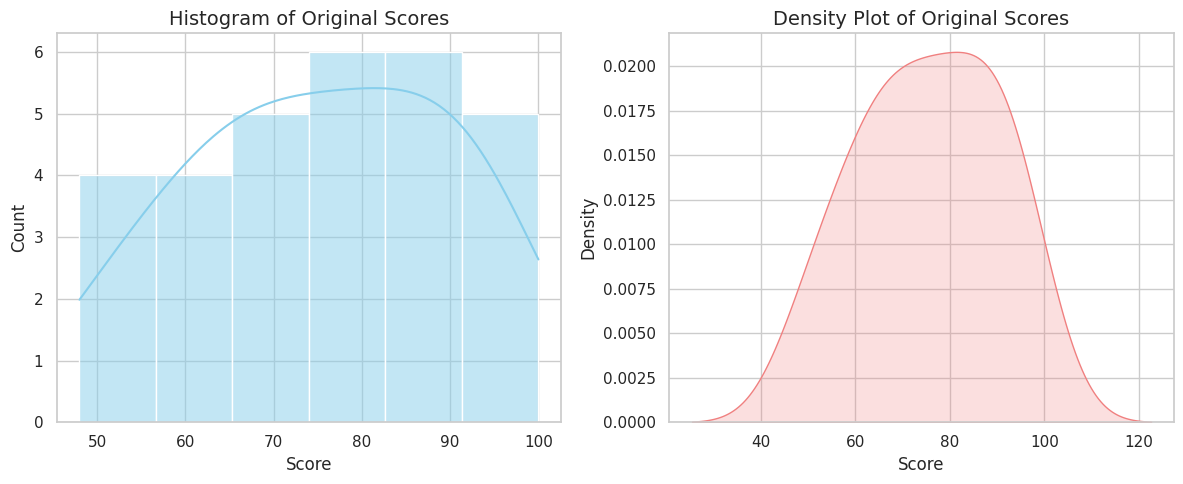

In [8]:
# Plot Original Scores Statistics

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
sns.histplot(df['Score'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Histogram of Original Scores", fontsize=14)
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Count")

# Density plot
sns.kdeplot(df['Score'], fill=True, ax=axes[1], color='lightcoral')
axes[1].set_title("Density Plot of Original Scores", fontsize=14)
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# Plot Final Grade Distribution


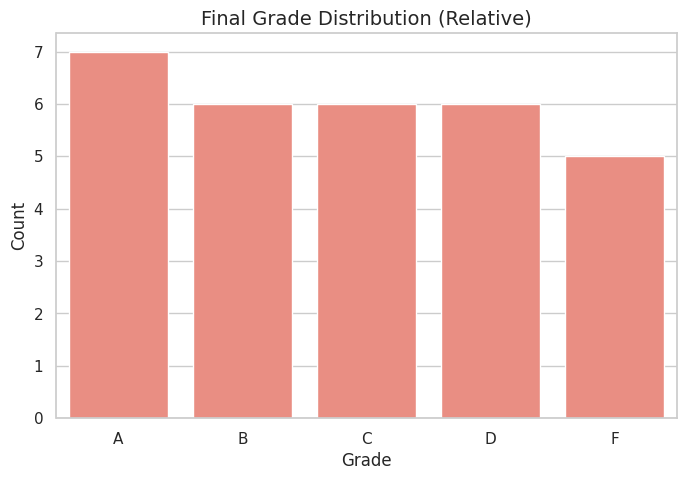

In [11]:
# Assuming df_grading is your DataFrame with the final grades
final_counts = df['Grade'].value_counts().sort_index()

# Assuming grading_method is defined somewhere in your notebook
grading_method = 'relative'  # or 'absolute'

plt.figure(figsize=(8, 5))
sns.barplot(x=final_counts.index, y=final_counts.values, color='salmon')
plt.title(f"Final Grade Distribution ({grading_method.capitalize()})", fontsize=14)
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

# Plot Adjusted Scores Analysis


In [14]:
# Histogram of Adjusted Scores
sns.histplot(df_final['AdjustedScore'], kde=True, ax=axes[0], color='blueviolet')
axes[0].set_title('Histogram of Adjusted Scores', fontsize=14)
axes[0].set_xlabel('AdjustedScore')
axes[0].set_ylabel('Count')

# Density Plot of Adjusted Scores
sns.kdeplot(df_final['AdjustedScore'], fill=True, ax=axes[1], color='goldenrod')
axes[1].set_title('Density Plot of Adjusted Scores', fontsize=14)
axes[1].set_xlabel('AdjustedScore')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

# Compare Absolute and Relative Grades


Number of students who changed letter grade compared to absolute grading: 0



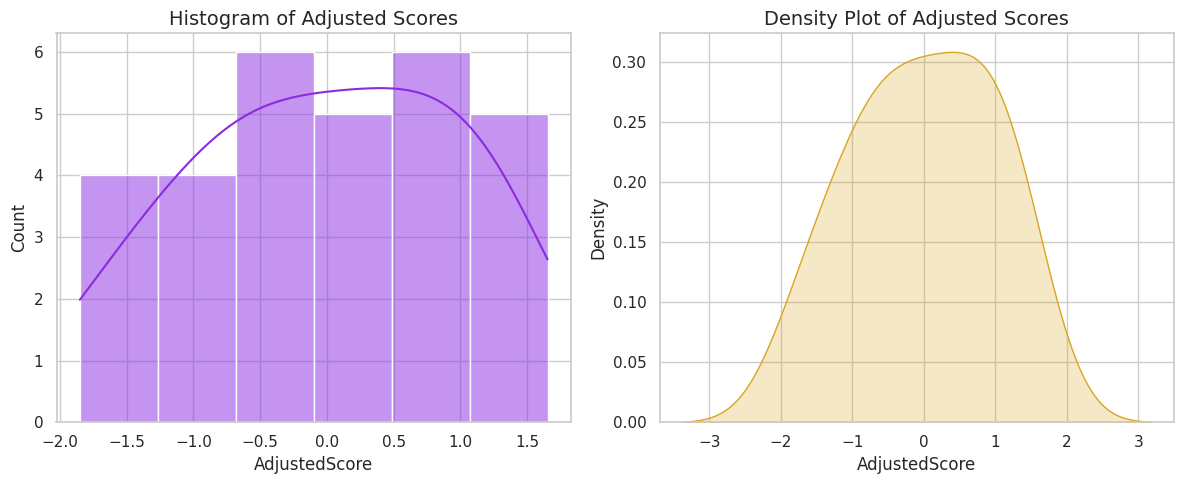

In [20]:
# Compare absolute and relative grades
df_abs_compare = df.copy()
df_abs_compare['AbsGrade'] = df_abs_compare['Score'].apply(assign_absolute_grade)
merged = pd.merge(df_abs_compare[['StudentID', 'AbsGrade']], df_final[['StudentID', 'Grade']], on='StudentID', how='left')
merged['Changed'] = merged['AbsGrade'] != merged['Grade']
changed_count = merged['Changed'].sum()

print(f'Number of students who changed letter grade compared to absolute grading: {changed_count}\n')

# Plot Adjusted Scores
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of Adjusted Scores
sns.histplot(df_final['AdjustedScore'], kde=True, ax=axes[0], color='blueviolet')
axes[0].set_title('Histogram of Adjusted Scores', fontsize=14)
axes[0].set_xlabel('AdjustedScore')
axes[0].set_ylabel('Count')

# Density Plot of Adjusted Scores
sns.kdeplot(df_final['AdjustedScore'], fill=True, ax=axes[1], color='goldenrod')
axes[1].set_title('Density Plot of Adjusted Scores', fontsize=14)
axes[1].set_xlabel('AdjustedScore')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [22]:
file_path = '/content/StudentScores.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,StudentID,Score
0,1,97
1,2,81
2,3,74
3,4,62
4,5,88


In [23]:
# Check the shape of the dataset
data.shape

(30, 2)

In [24]:
# Generate descriptive statistics
data.describe()

,StudentID,Score
count,30.000000,30.000000
mean,15.500000,75.466667
std,8.803408,14.834102
min,1.000000,48.000000
25%,8.250000,65.250000
50%,15.500000,76.000000
75%,22.750000,87.750000
max,30.000000,100.000000


In [25]:
# Count missing values in each column
data.isnull().sum()

,0
StudentID,0
Score,0


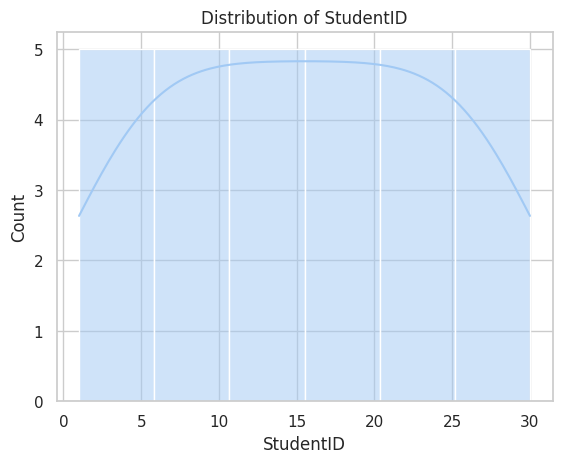

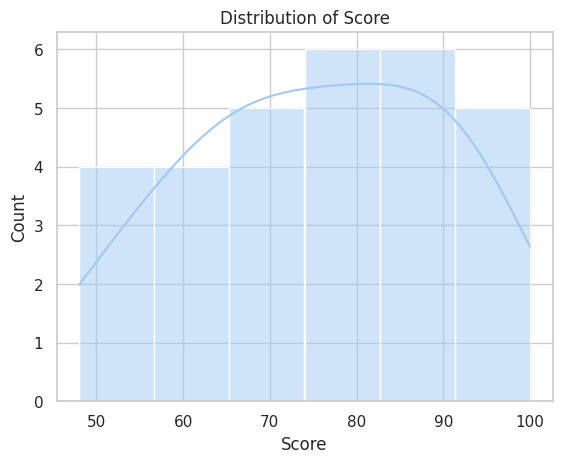

In [26]:
# Example: Plot the distribution of a numerical column
for column in data.select_dtypes(include='number').columns:
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

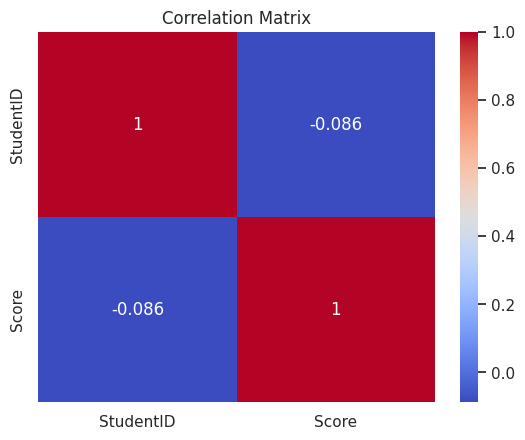

In [27]:
# Compute and plot the correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()